<a href="https://colab.research.google.com/github/Charlee0616/Data-Mining/blob/main/K_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
iris = load_iris()

In [3]:
df = pd.DataFrame( iris.data, columns = iris.feature_names)

In [4]:
true_labels = iris.target

In [5]:
def inertia(data, centroids, labels): #calculates "inertia", the sum of squared distances between each data point and its assigned cluster
  inertia = 0
  for i, point in enumerate(data):
    centroid_idx = int(labels[i])
    inertia += np.sum((point - centroids[centroid_idx])**2)
  return inertia

In [6]:
def kmeansplus(df, k):
  centroids = [df.iloc[np.random.choice(range(df.shape[0]))].values]
  for i in range(1, k):
    distances = np.array([min([np.linalg.norm(point - c)**2 for c in centroids]) for point in df.values])
    probabilities = distances / np.sum(distances)
    next_centroid = df.iloc[np.random.choice(range(df.shape[0]), p=probabilities)].values
    centroids.append(next_centroid)
  return np.array(centroids)


In [7]:
def Kmeans(df, k, method = "random", max_iters=100):
  if isinstance(df, np.ndarray):
    df = pd.DataFrame(df)
#the three different methods for initializing the clusters
  if method == "random": #randomly selects data points as initial centroids
    centroids = df.iloc[np.random.choice(df.shape[0], k, replace=False)]
  elif method == "picked": #selectes the first k data points as the initial centroids
    centroids = df.iloc[:k]
  elif method == "kmeans++": #selects the initial centroids using a strategy that spreads out the inital centroids
    centroids = kmeansplus(df, k)

  data = df.values
  labels = np.zeros(data.shape[0]) #converts data into NumPy array for computation
  for i in range(max_iters):
    for idx, point in enumerate(data):
      distances = np.sqrt(np.sum((point - centroids)**2, axis=1)) #calculates euclidean distance
      labels[idx] = np.argmin(distances) #data points assigned to centroids based on their distance
    new_centroids = np.array([data[labels == j].mean(axis=0) for j in range(k)]) #new centroids are created based on the mean of the points in each cluster
    if np.all(centroids == new_centroids): #process repeats until the centroids stop moving or max iterations are reached
        break
    centroids = new_centroids
#plotting the kmeans cluster method results for each iteration
    plt.figure(figsize=(8,6))
    for j in range(k):
      plt.scatter(data[labels == j, 0], data[labels == j, 1], label=f"Cluster {j+1}")
    plt.scatter(centroids[:, 0], centroids[:, 1], color = 'black', marker='X', s=200, label = "Centroids")
    plt.title(f"K-Means Clustering (Iteration {i+1})")
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.show()
  calc_inertia = inertia(data, centroids, labels)
  return centroids, labels, calc_inertia

# **K-Means Results**

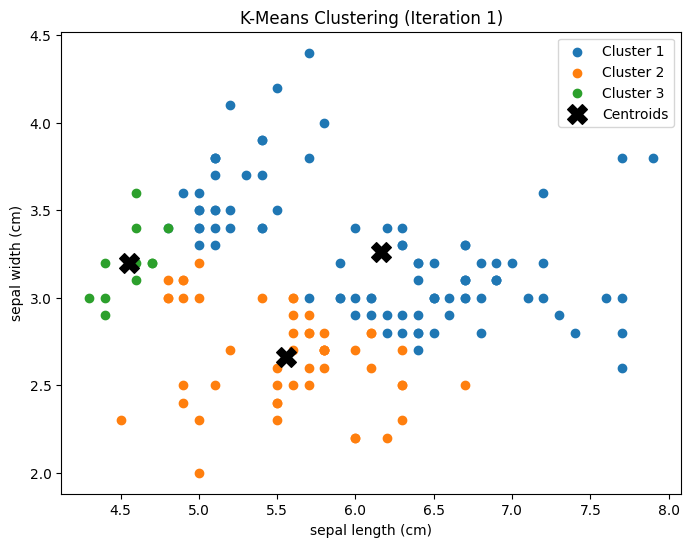

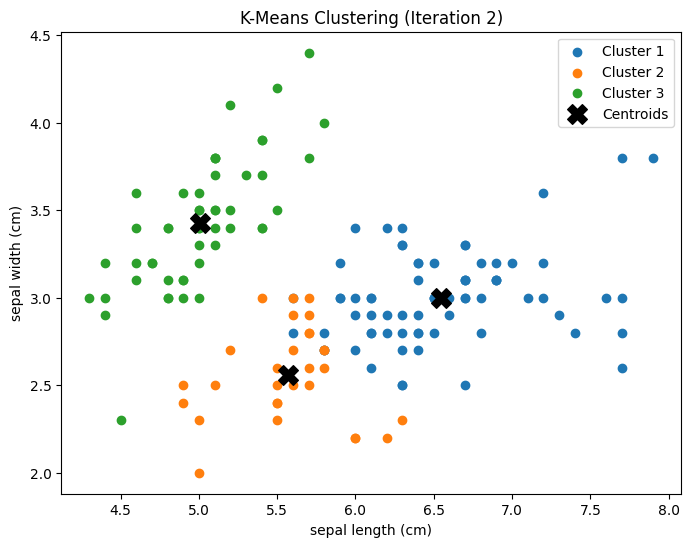

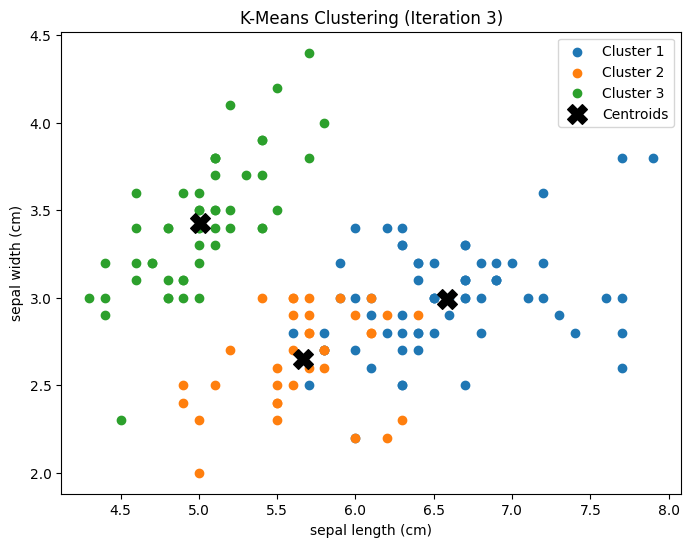

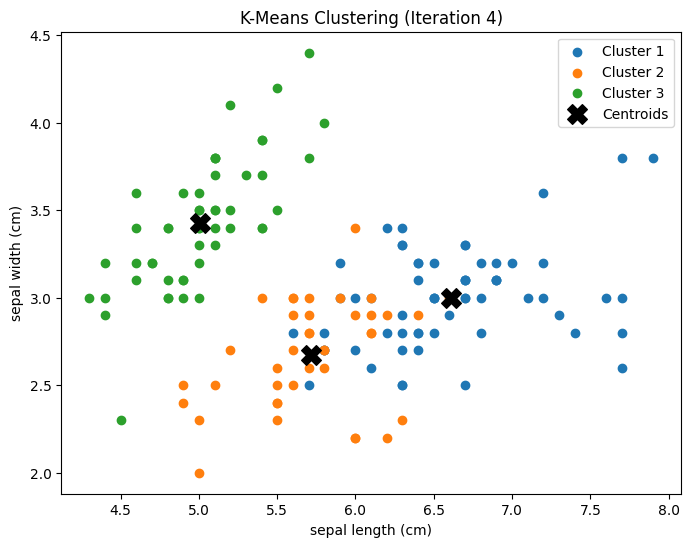

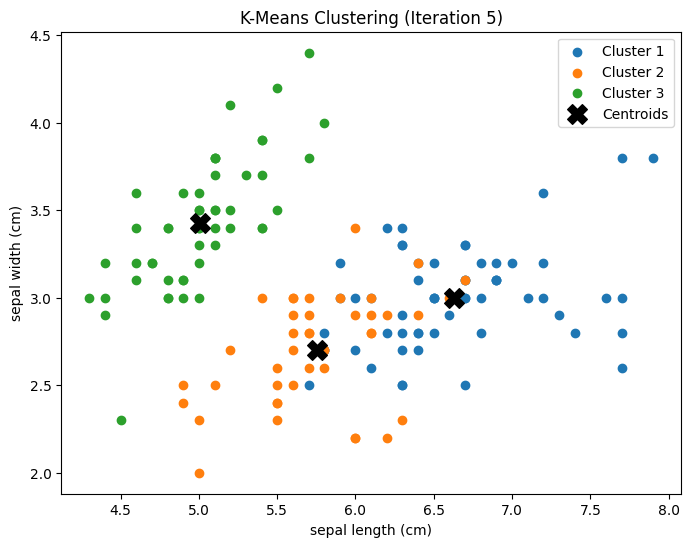

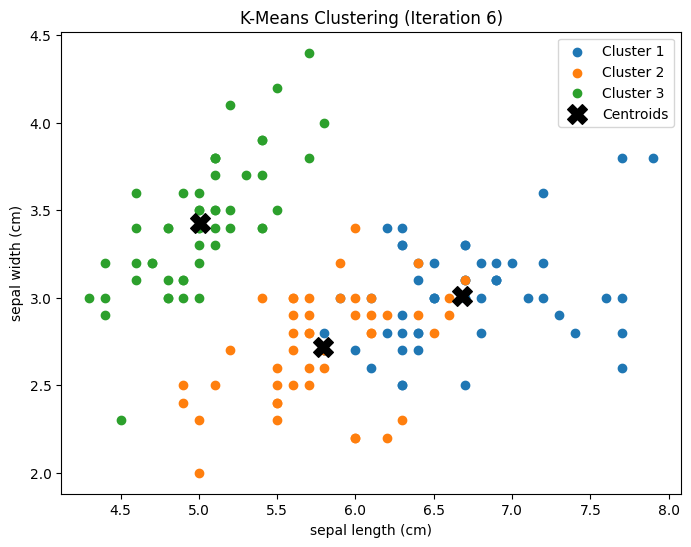

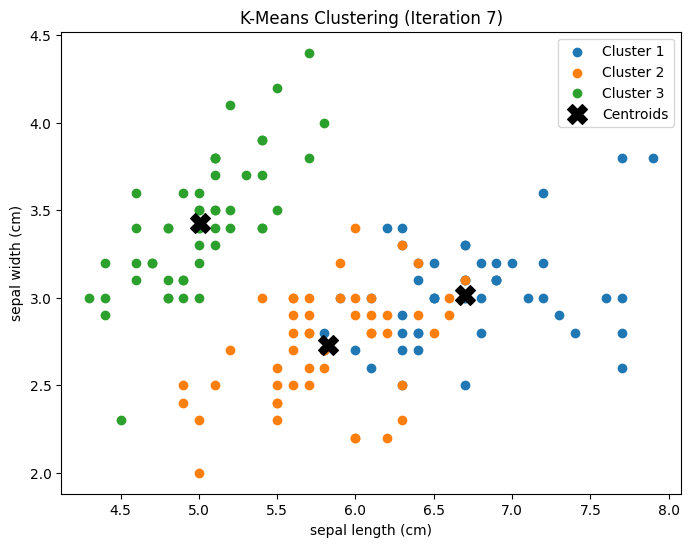

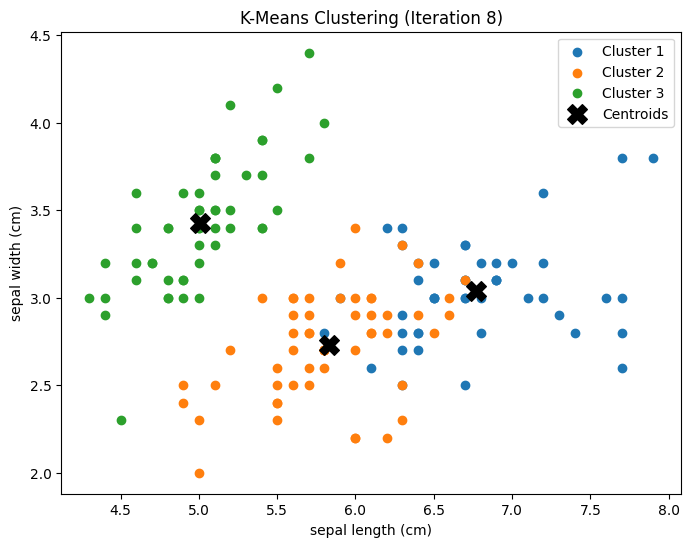

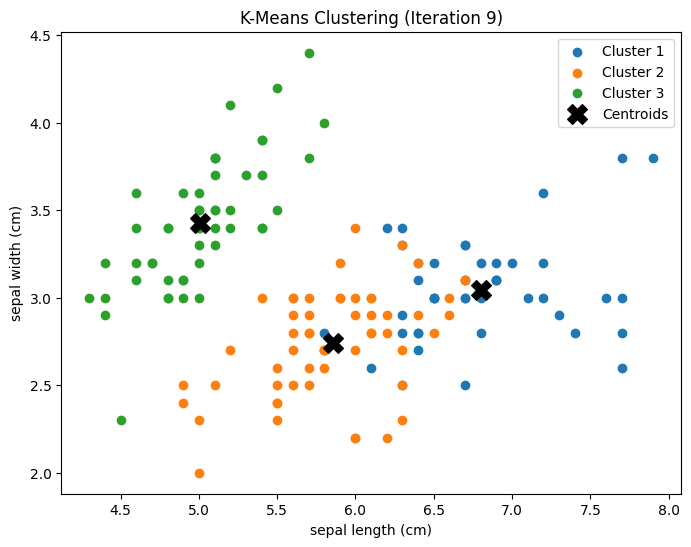

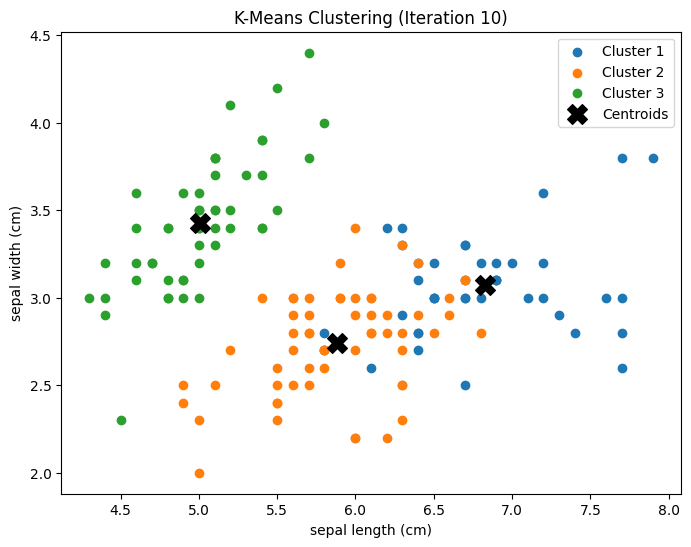

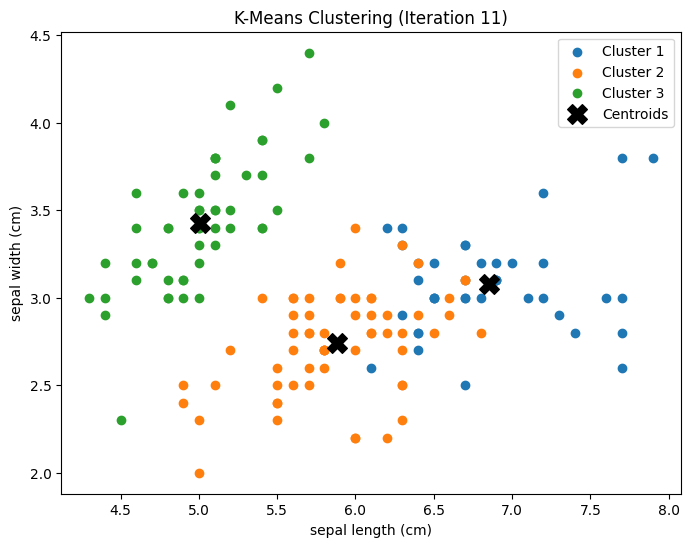

Inertia for picked initialization: 78.85566582597724


In [8]:
#testing the second method where the centroids are specified at the beginning
centroids_picked, labels_picked, inertia_picked = Kmeans(df, 3, method="picked")
print(f"Inertia for picked initialization: {inertia_picked}")

In [16]:
k=3

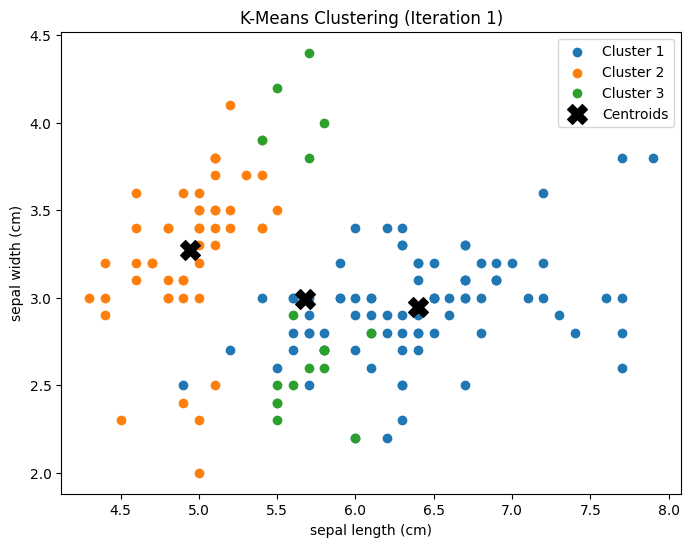

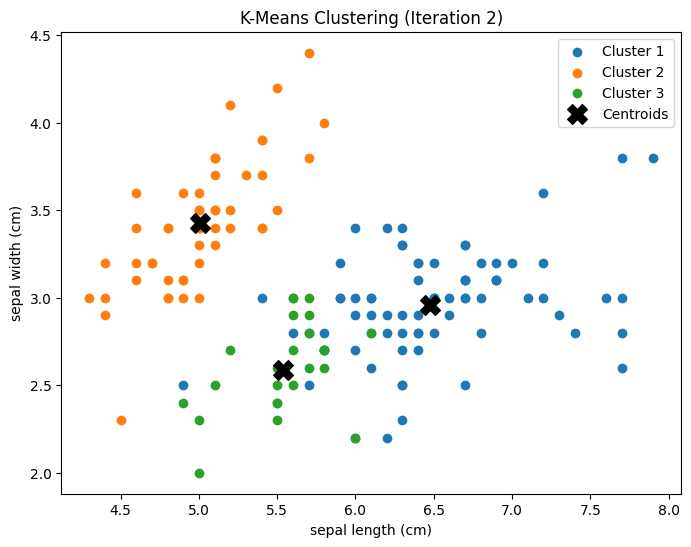

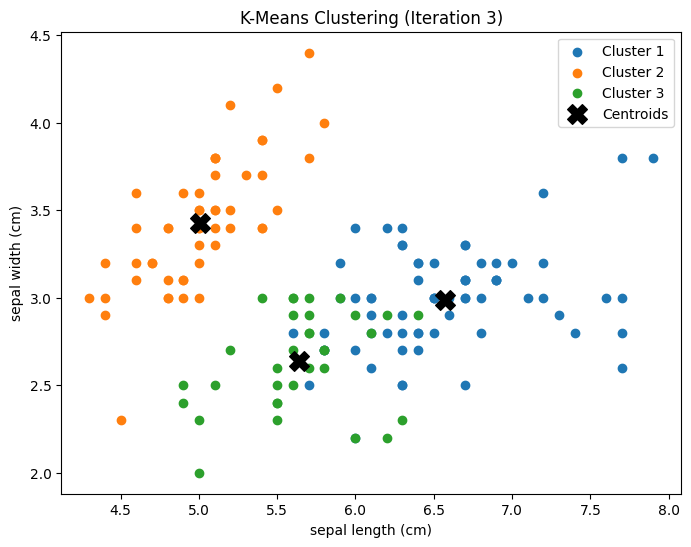

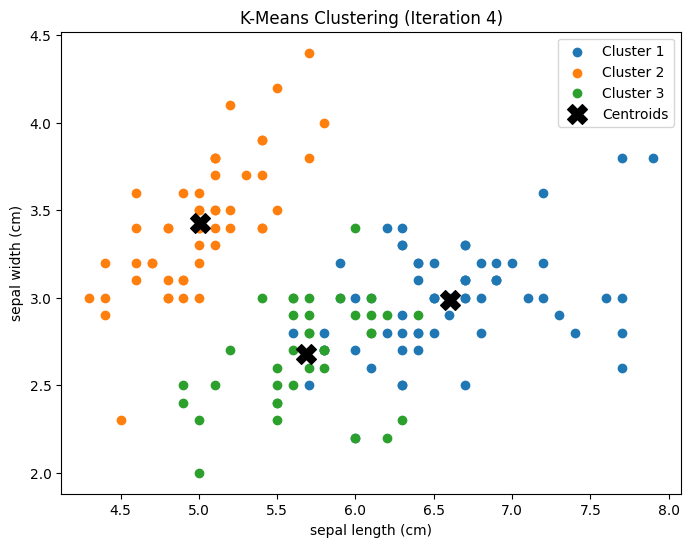

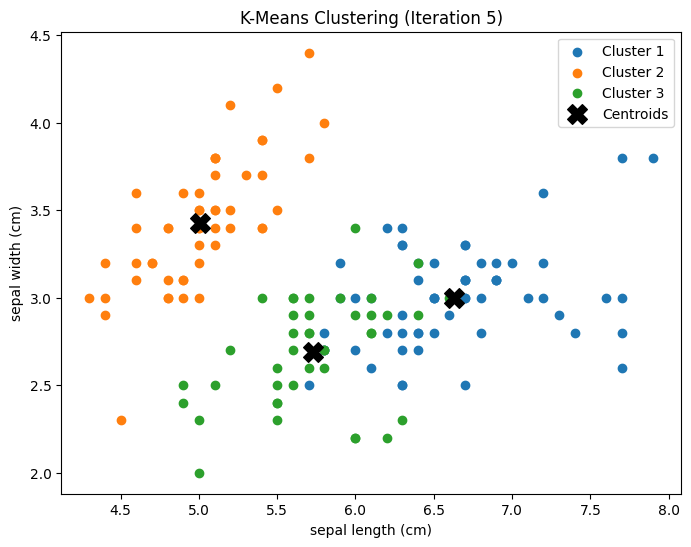

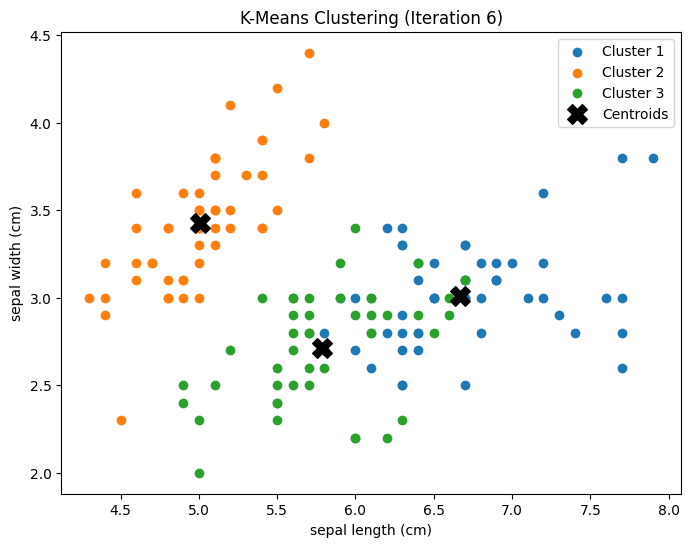

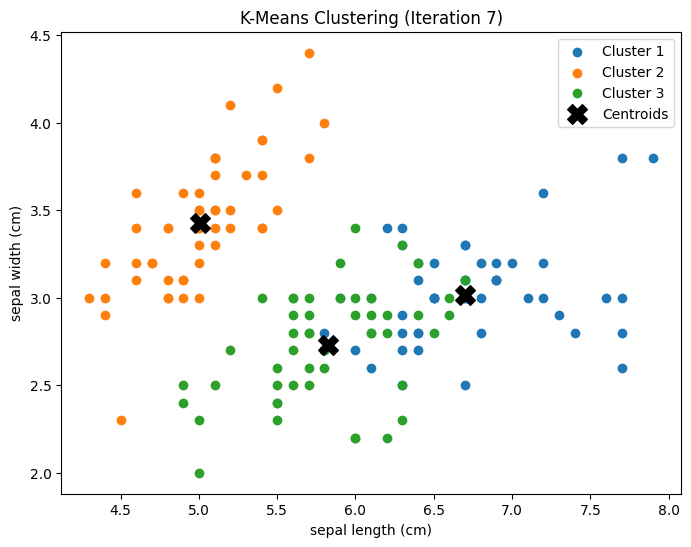

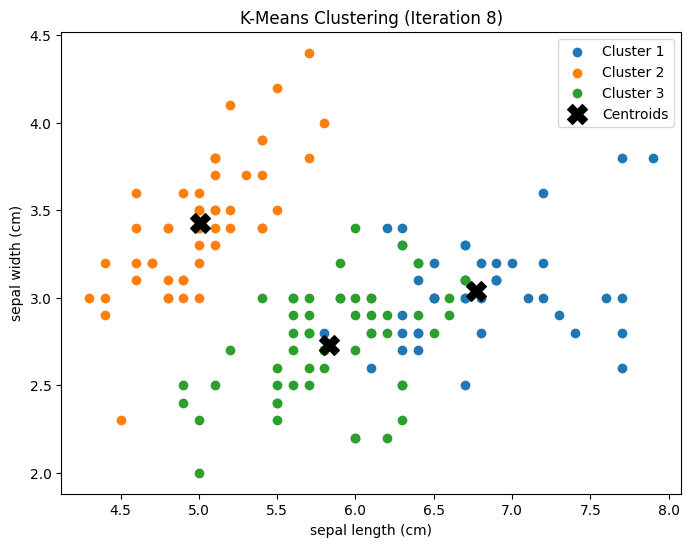

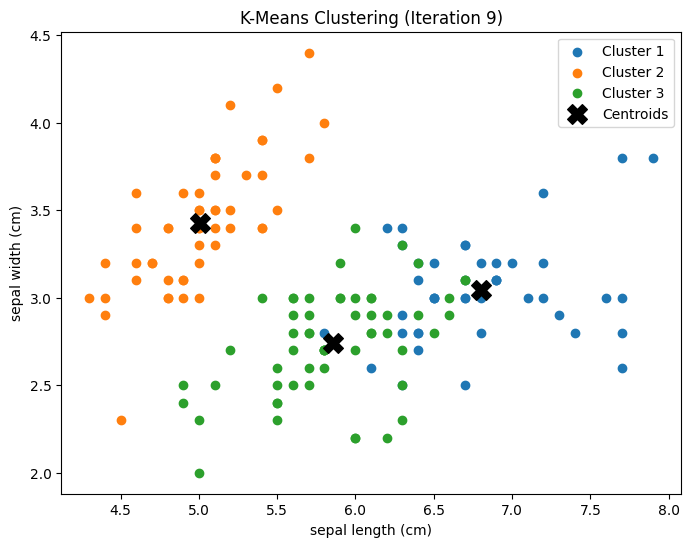

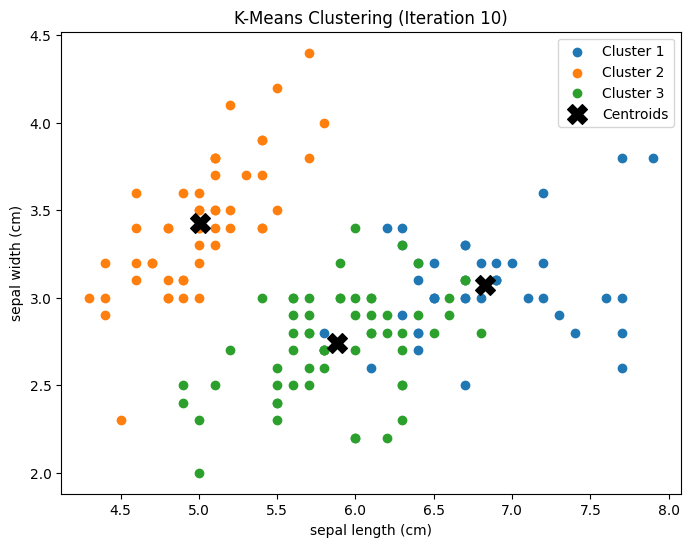

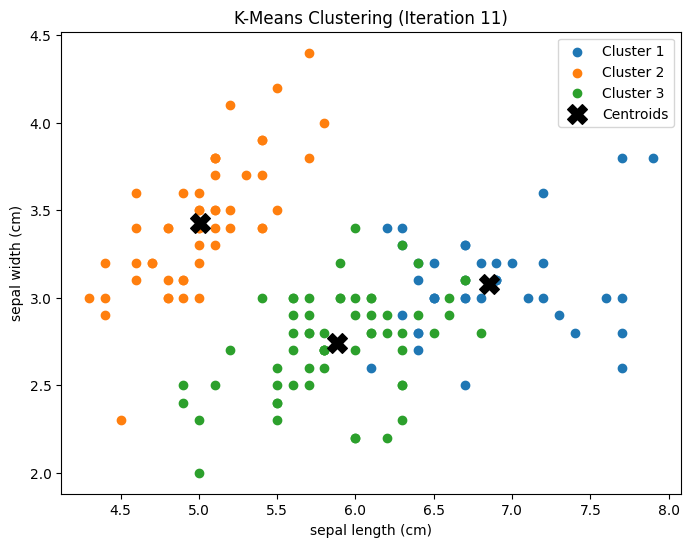

Inertia for random initialization: 78.85566582597724


In [17]:
#first method where the clusters are picked randomly
centroids_random, labels_random, inertia_random = Kmeans(df, k, method="random")
print(f"Inertia for random initialization: {inertia_random}")

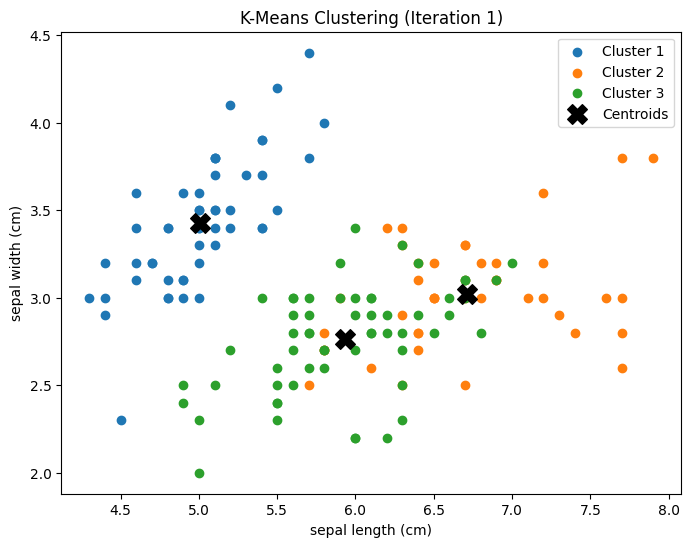

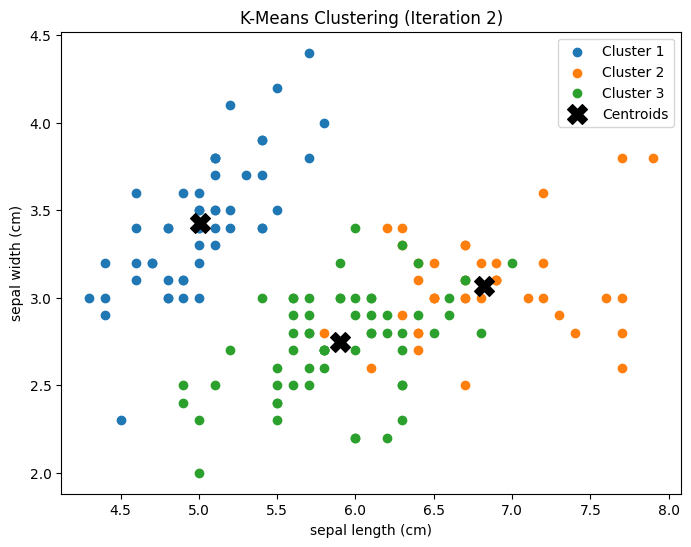

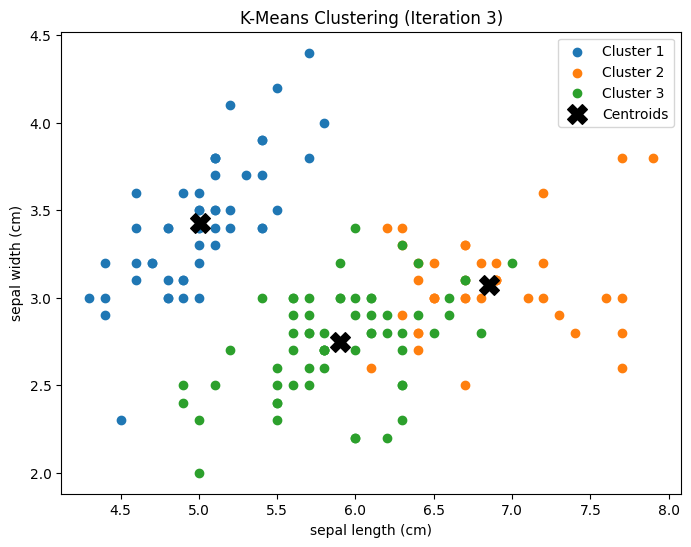

Inertia for kmeans++ initialization: 78.851441426146


In [18]:
#third method where the centroids are initialized as in Arthur and Vassilvitskii
centroids_kplus, labels_kplus, inertia_kplus = Kmeans(df, k, method="kmeans++")
print(f"Inertia for kmeans++ initialization: {inertia_kplus}")

# **Inertia Results/Elbow Graph**

In [13]:
def elbow_method(data, max_k=10, method="random"): #finds the best number of clusters based on the different intertia values
    inertias = []
    for k in range(1, max_k + 1):
        _, _, calc_inertia = Kmeans(df, k, method=method)
        inertias.append(calc_inertia)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k +1), inertias, marker='o', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


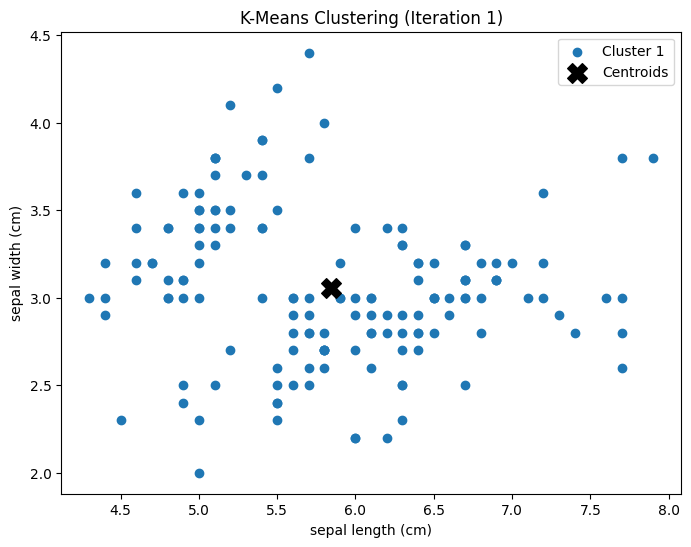

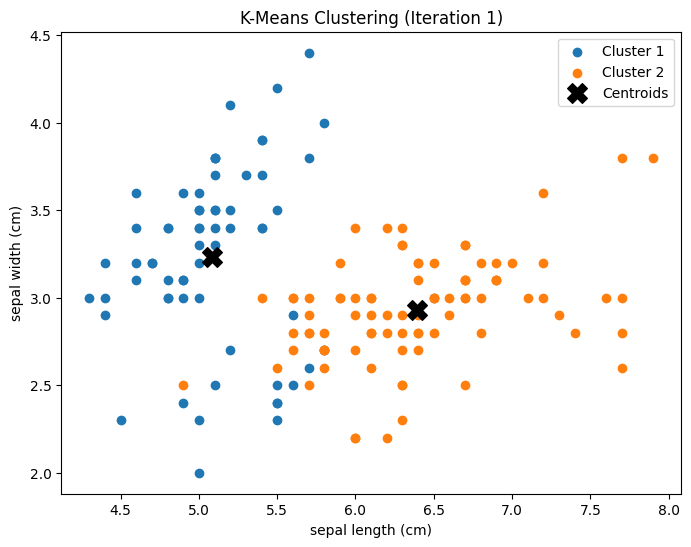

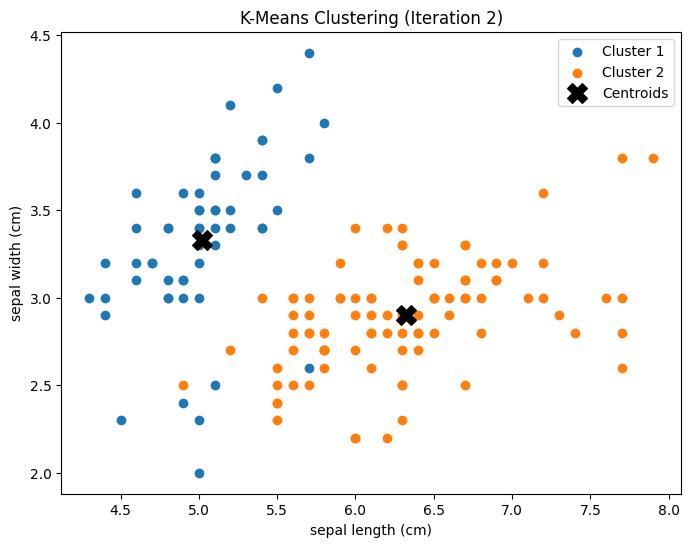

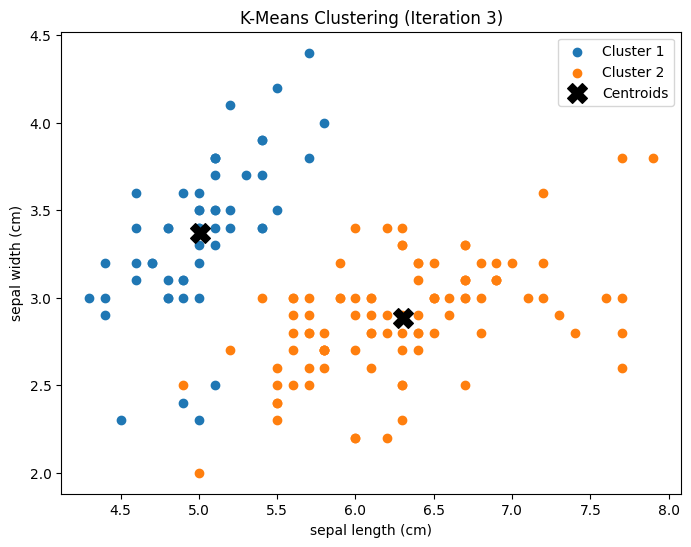

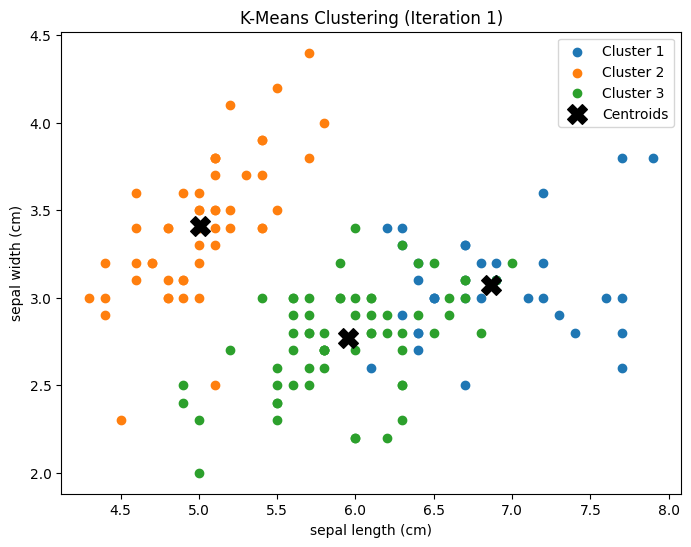

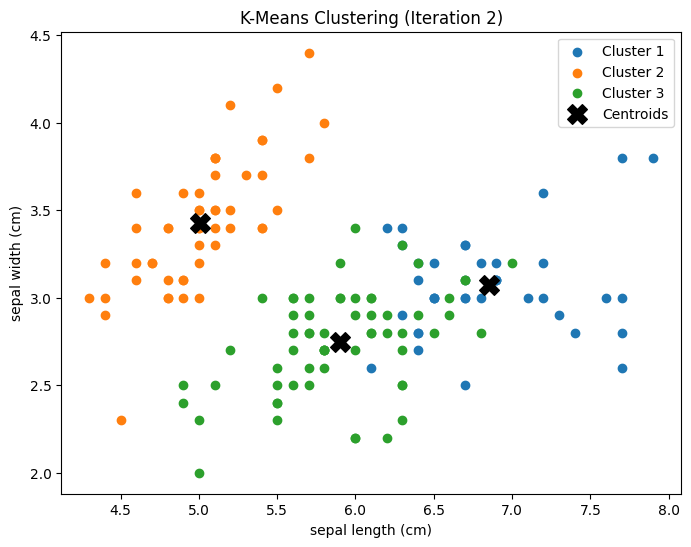

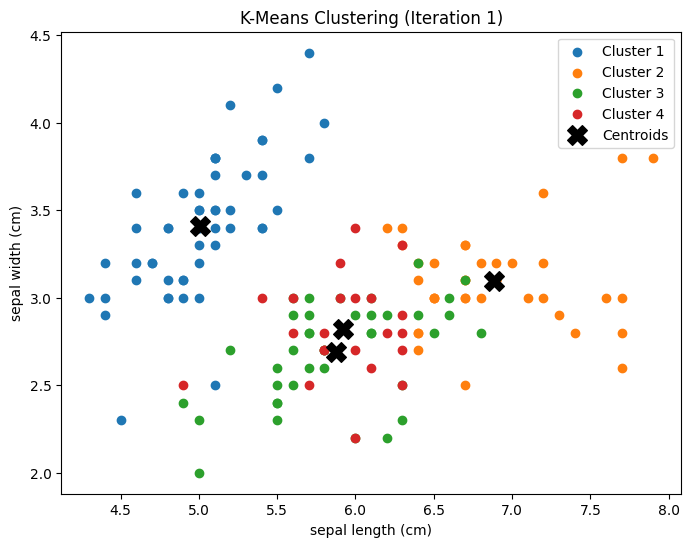

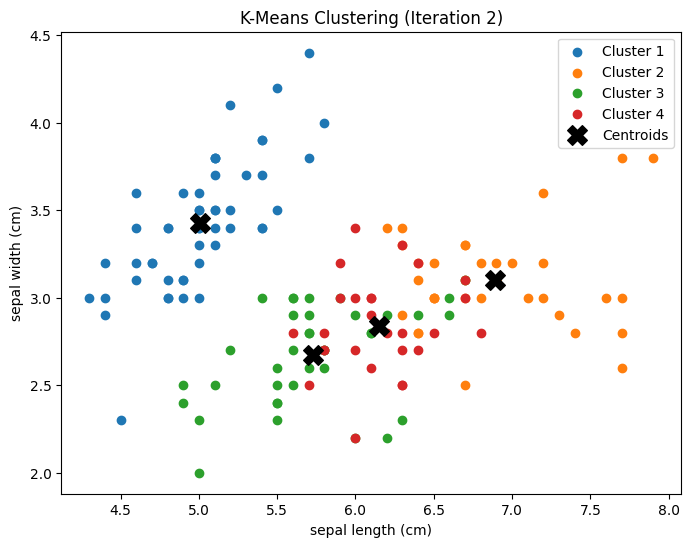

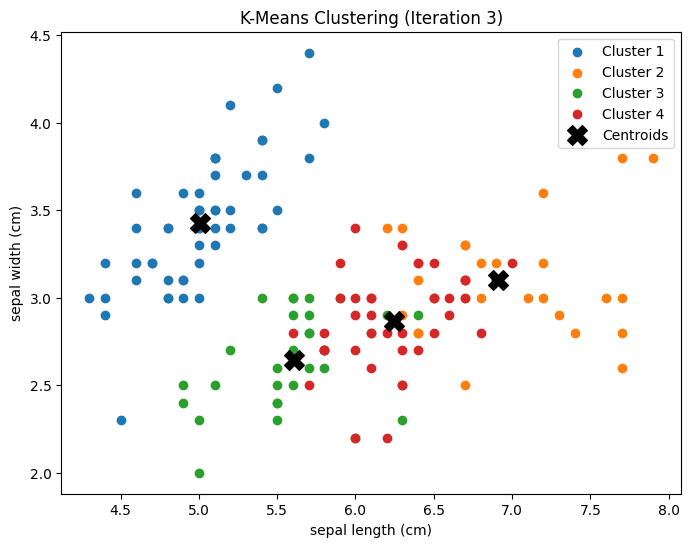

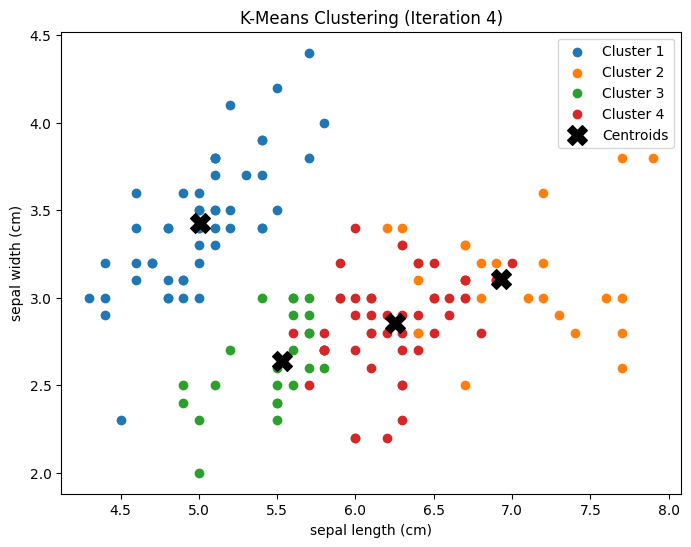

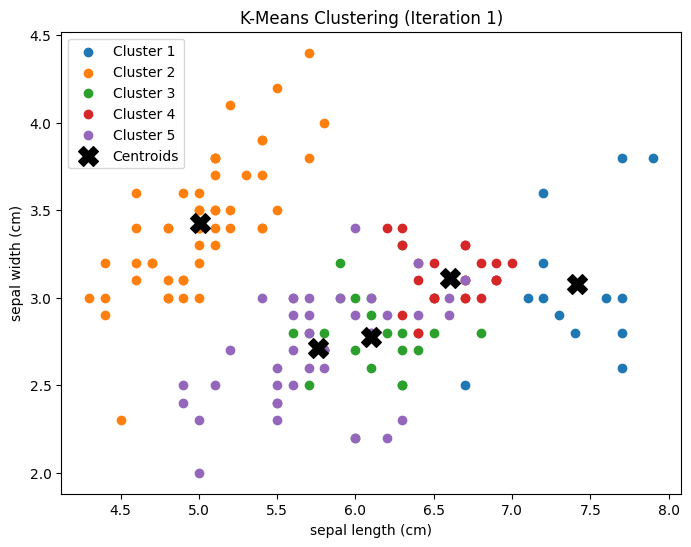

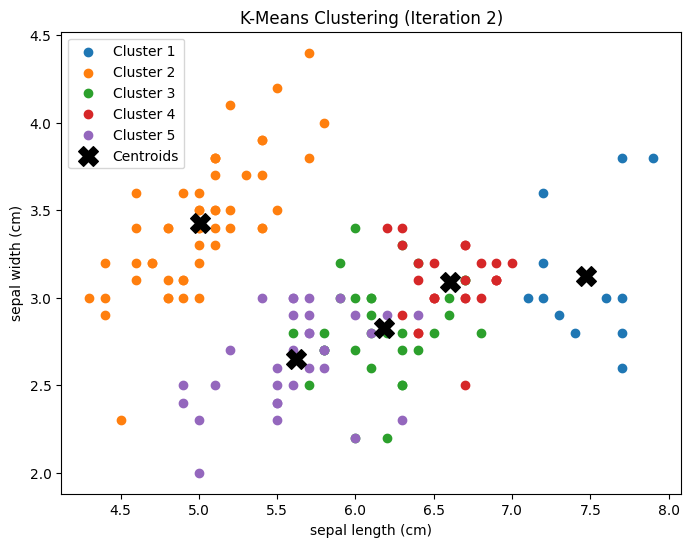

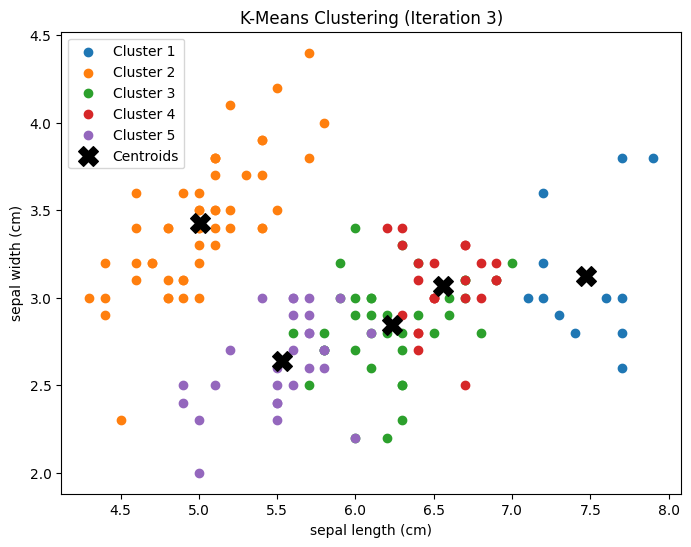

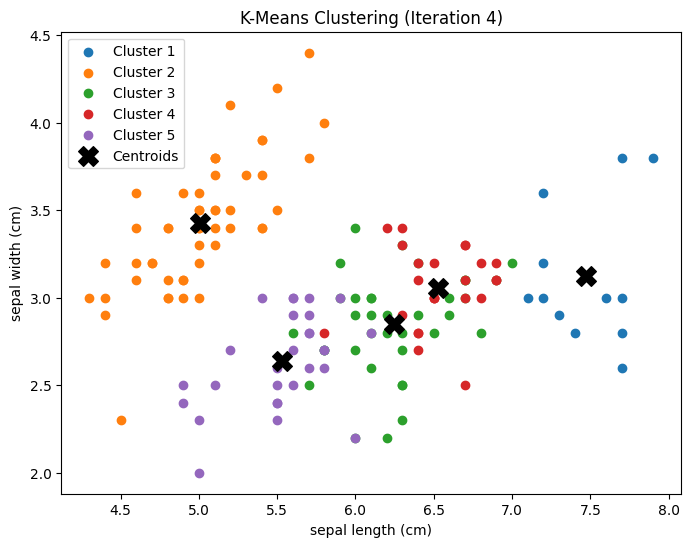

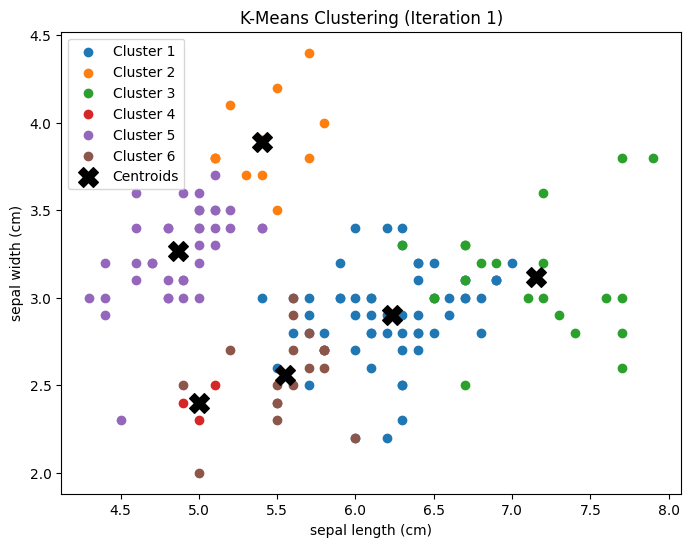

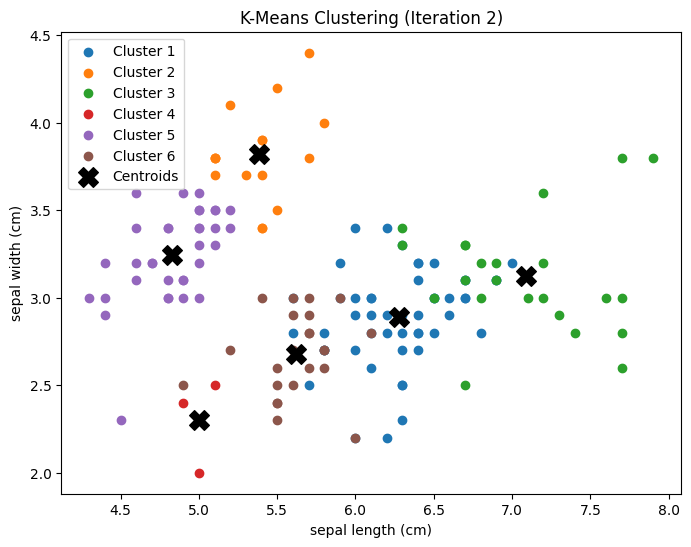

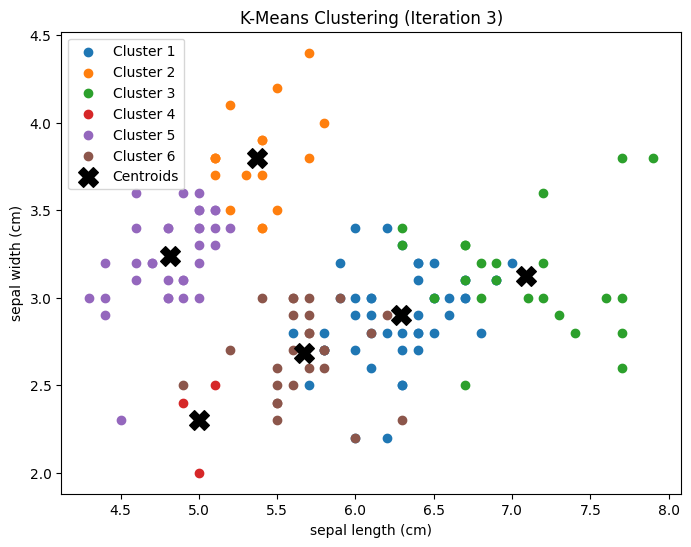

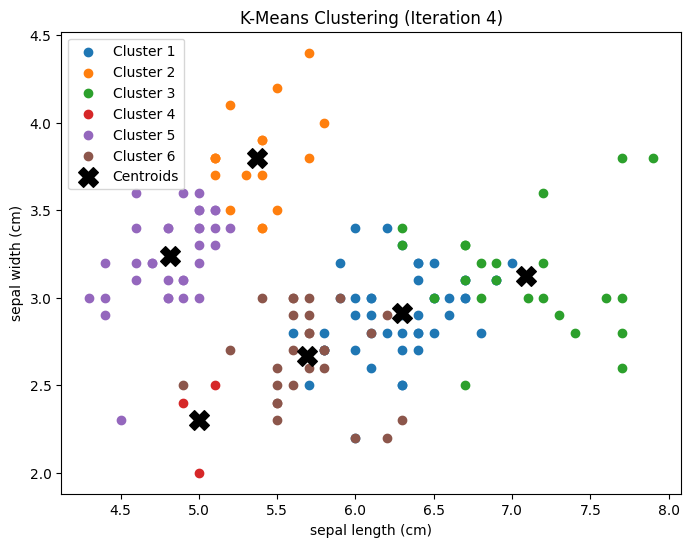

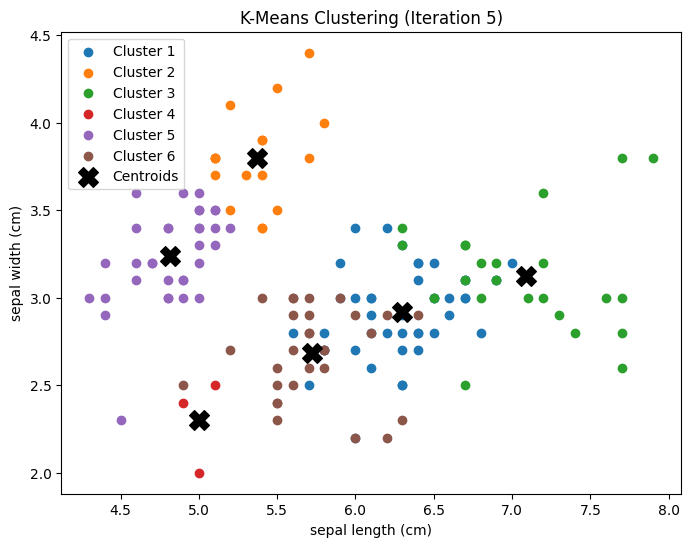

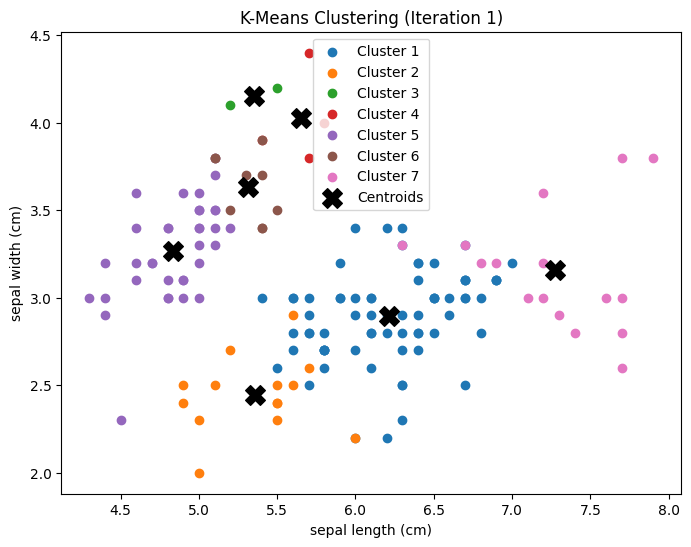

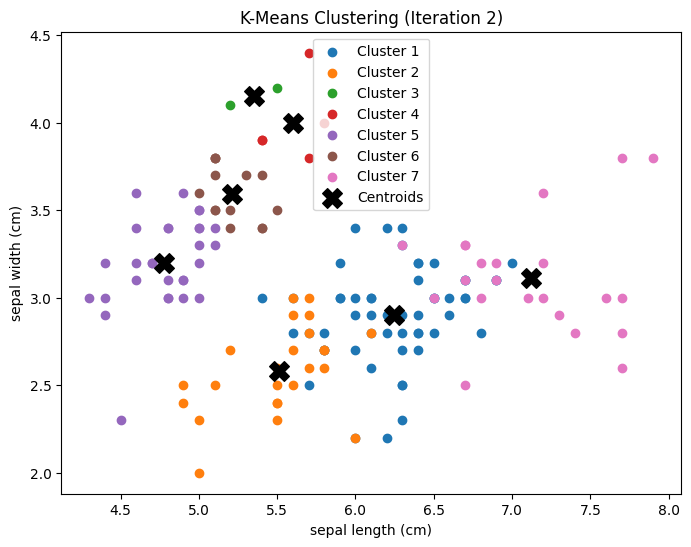

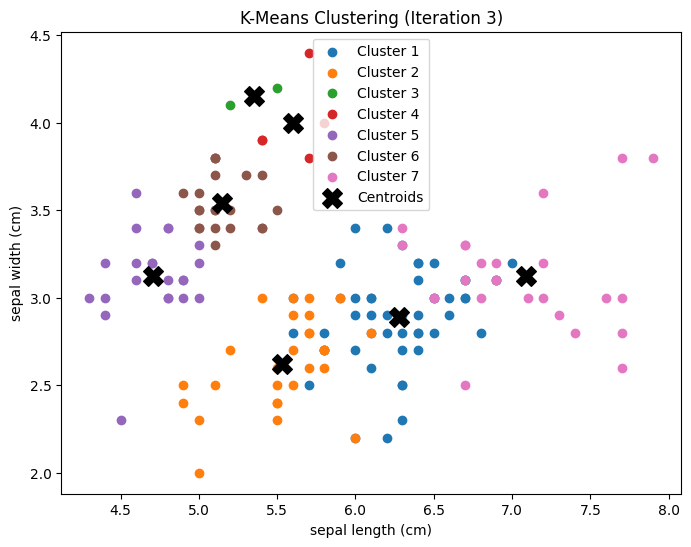

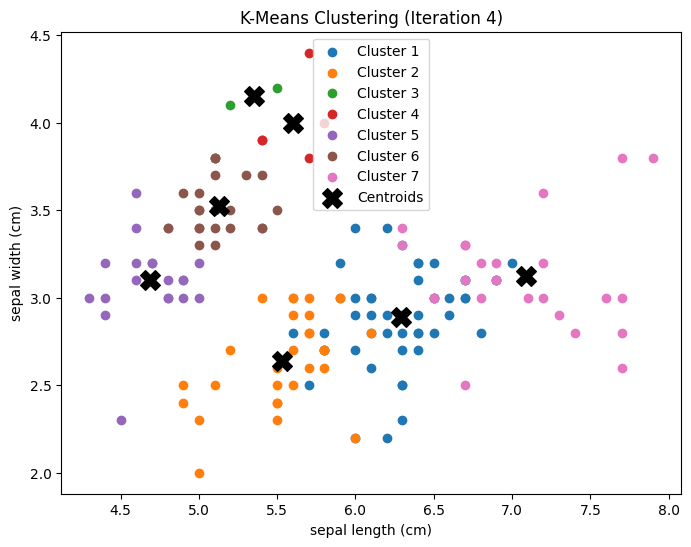

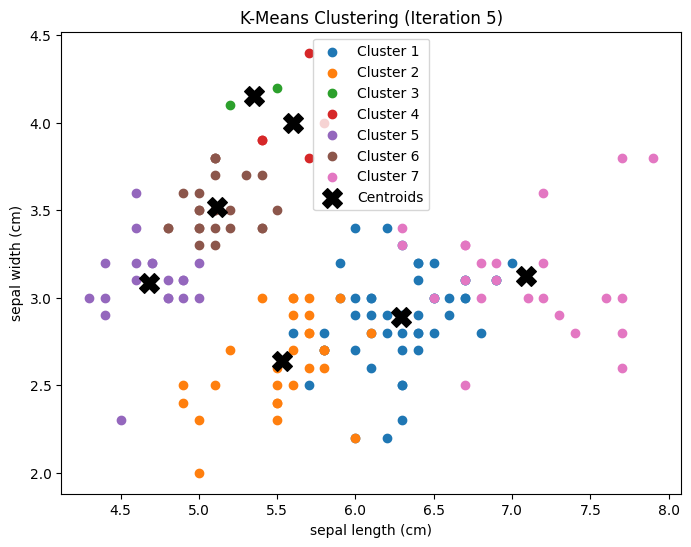

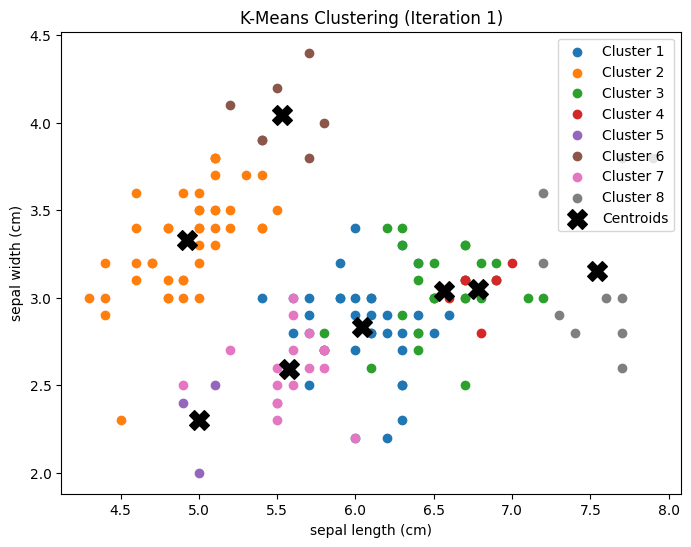

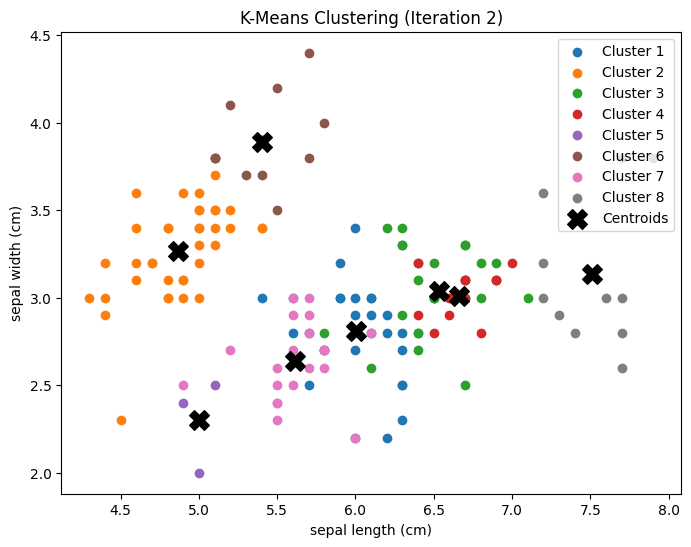

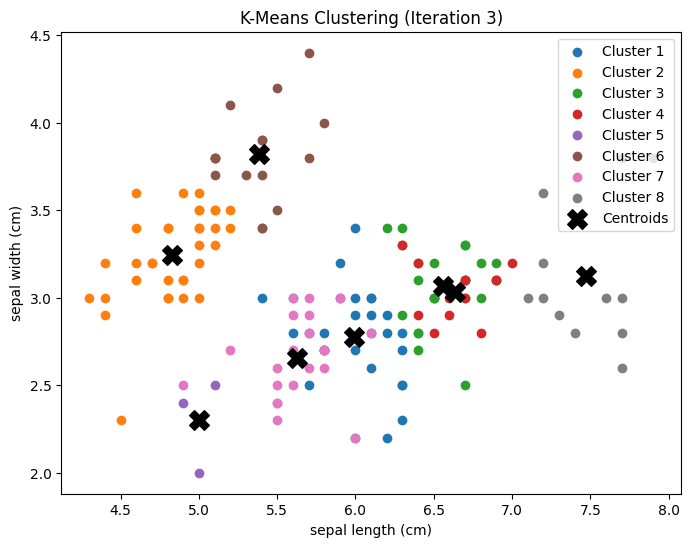

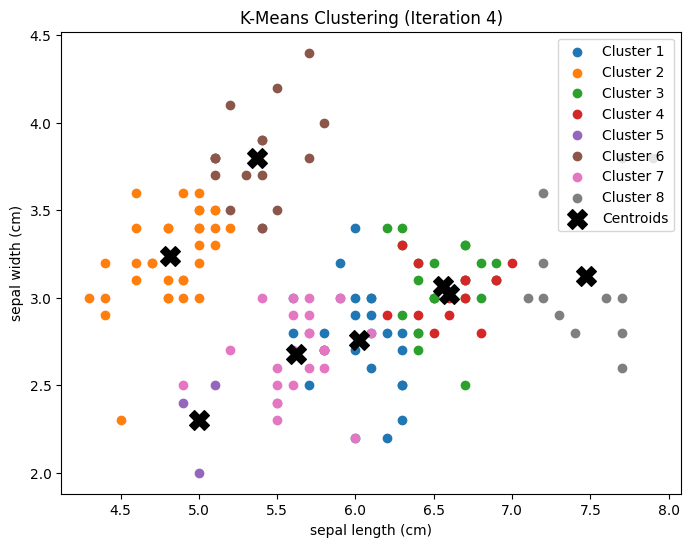

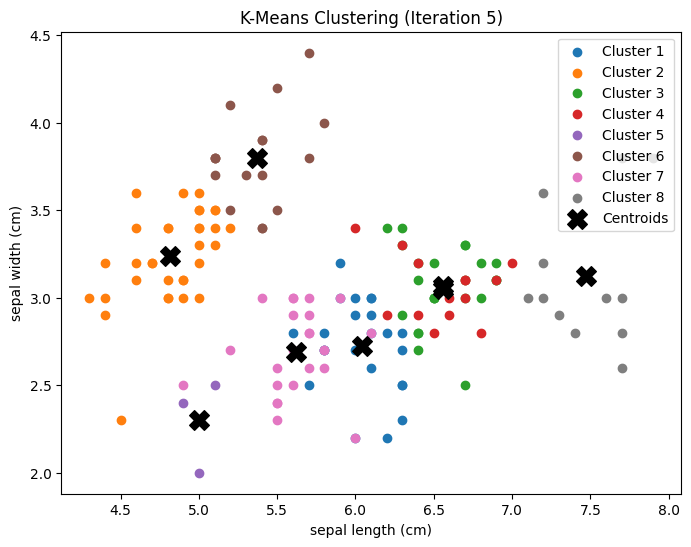

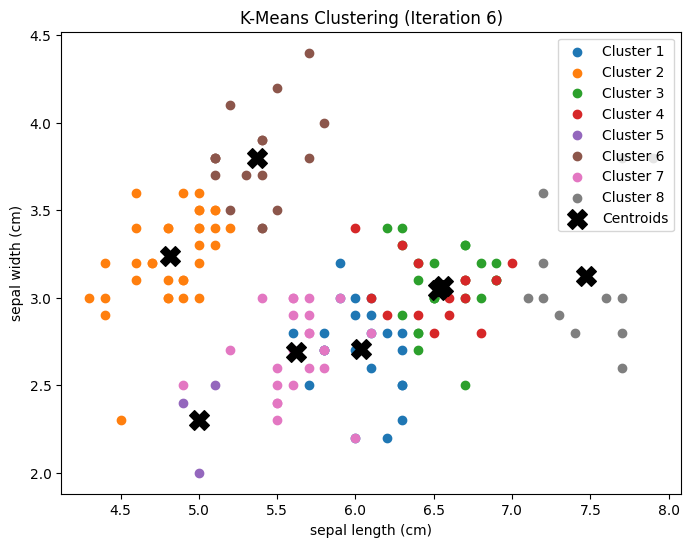

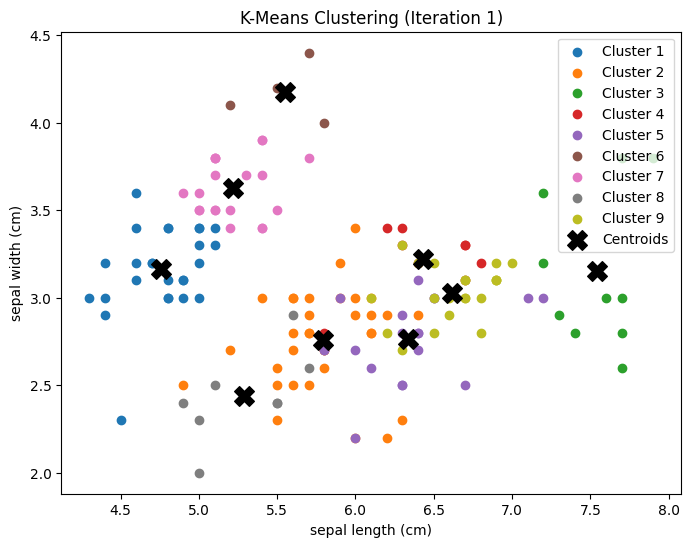

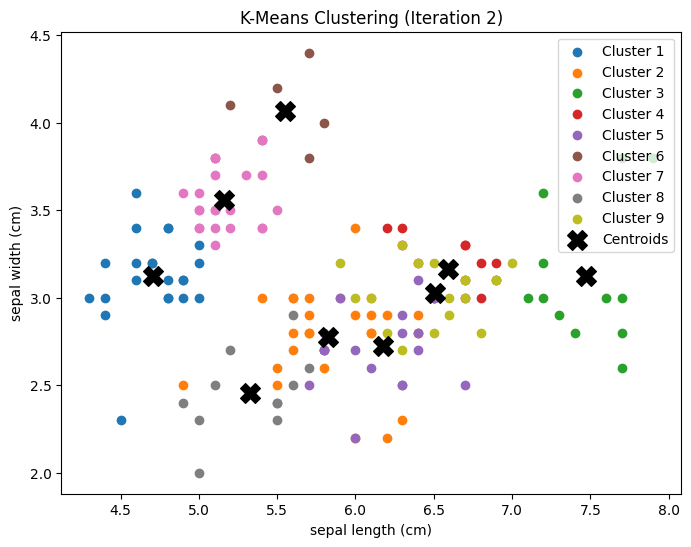

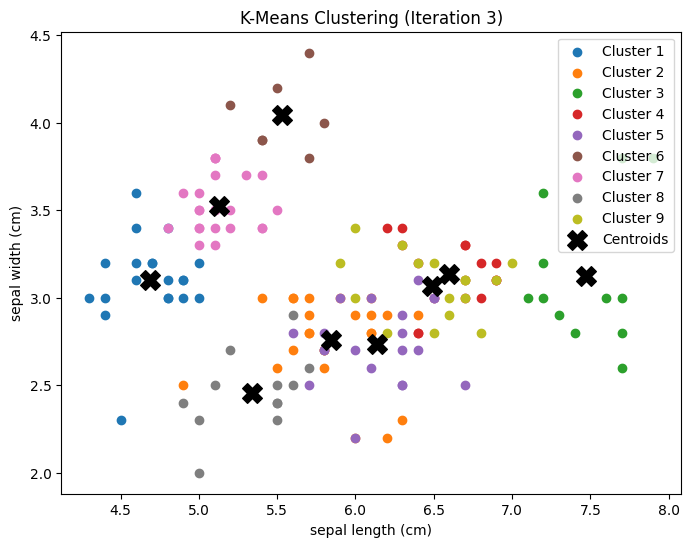

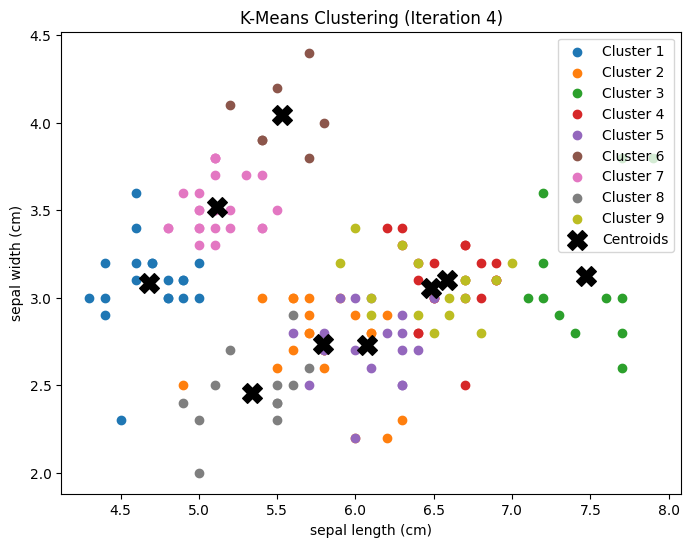

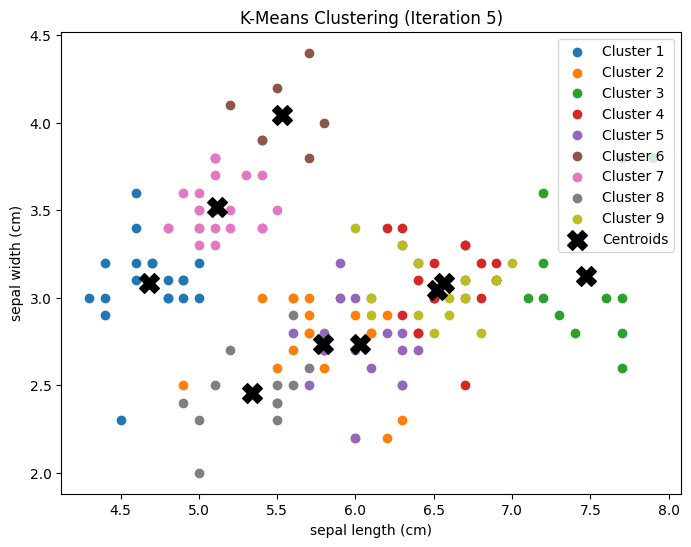

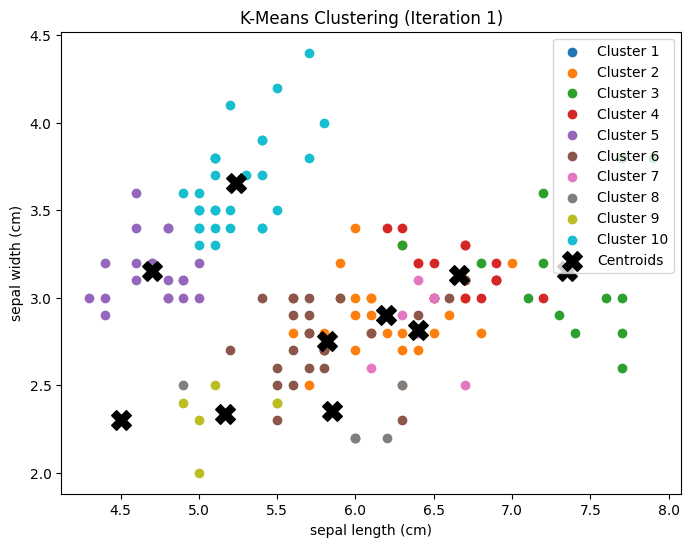

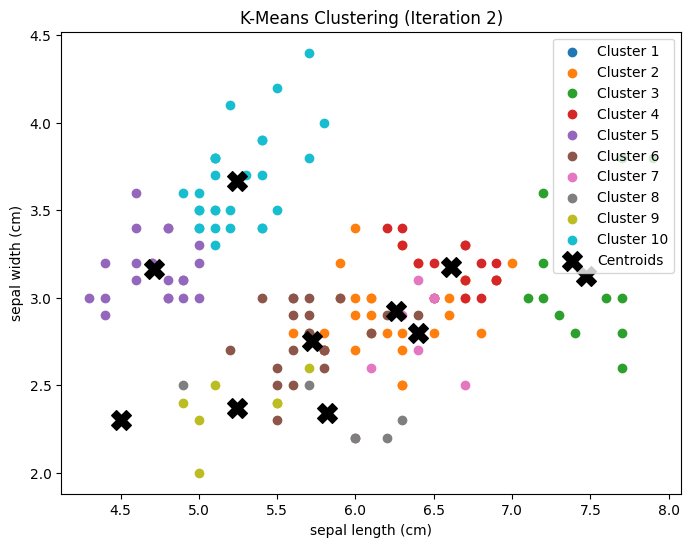

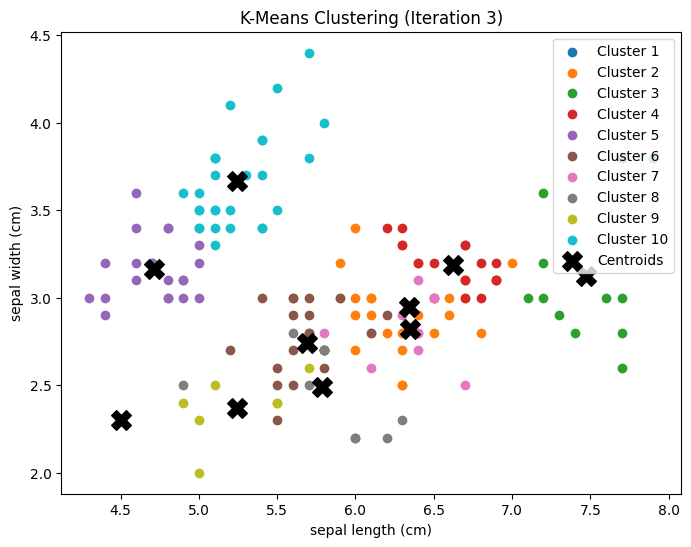

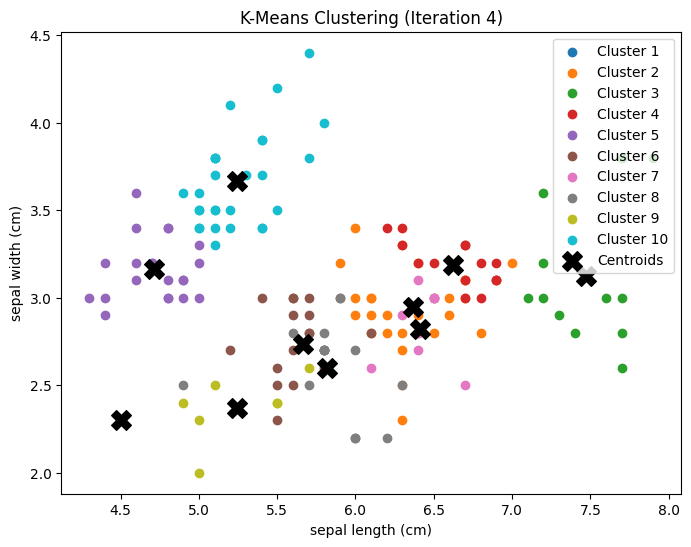

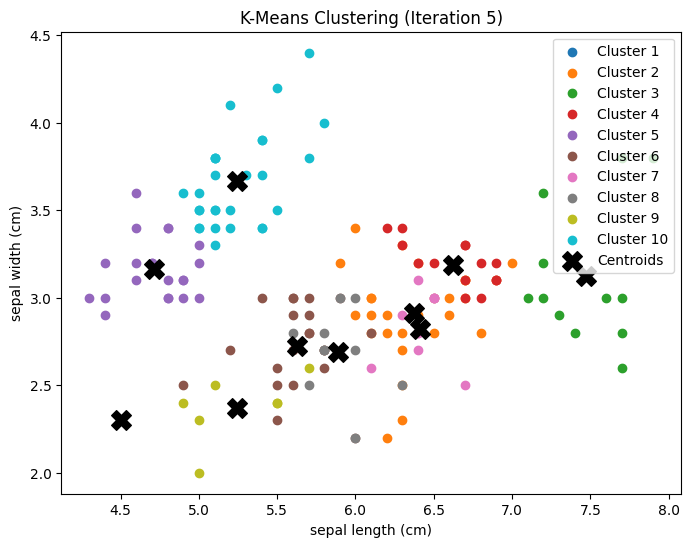

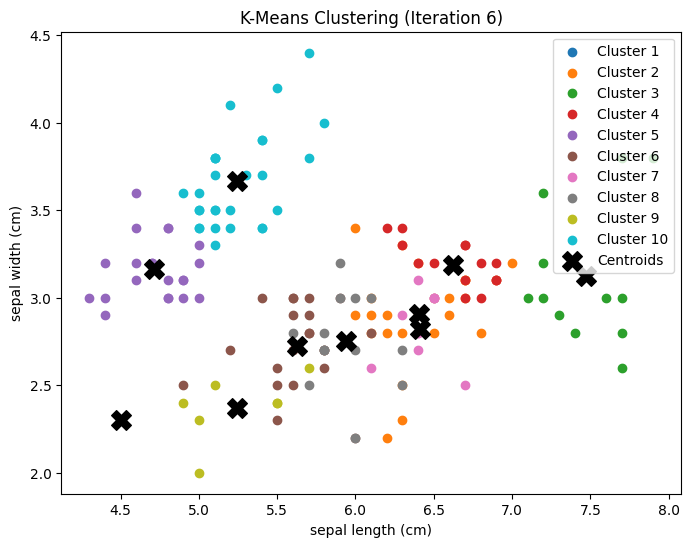

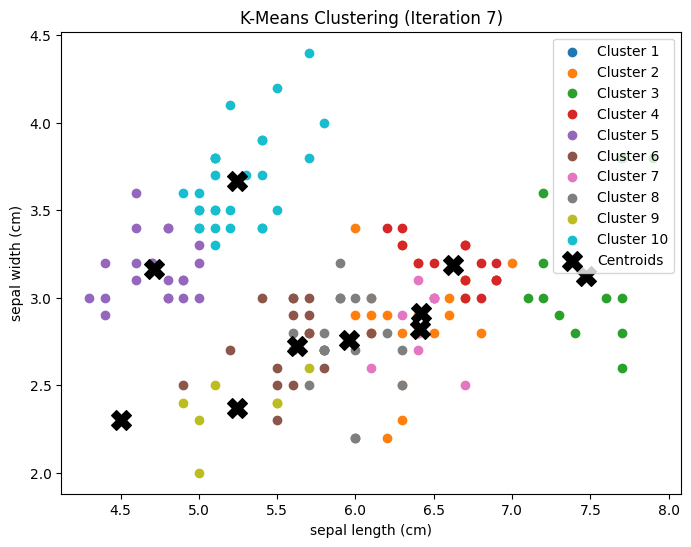

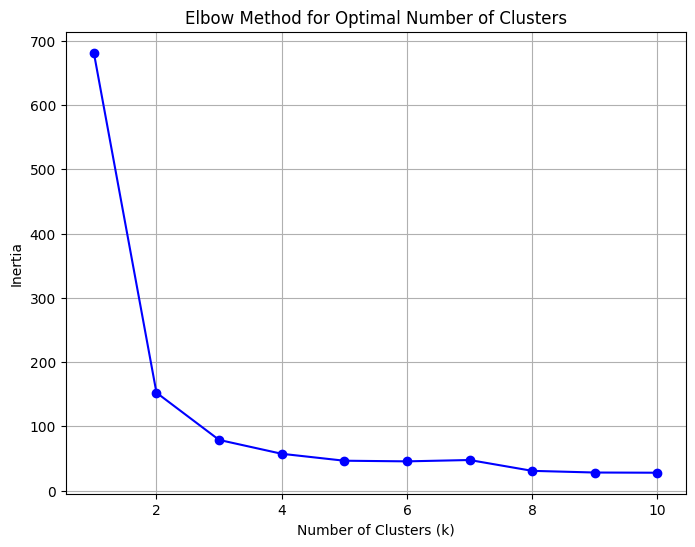

In [14]:
elbow_method(df,  method="kmeans++")

# **Silhouette Method**

In [15]:
def calculate_silhouette(data, labels): #measures how well-seperated the clusters are and how well the data points fit together in their clusters
    silhouette_avg = silhouette_score(data, labels) #average silhouette score for the dataset
    sample_silhouette_values = silhouette_samples(data, labels) #a list of the silhouette scores for individual data points
    return silhouette_avg, sample_silhouette_values

In [19]:
def visualize_silhouette(data, labels):
    silhouette_avg, sample_silhouette_values = calculate_silhouette(data, labels)
    # Create a plot for silhouette scores
    plt.figure(figsize=(8, 6))
    y_lower, y_upper = 0, 0
    for i in range(len(np.unique(labels))):
        # Get silhouette scores for each cluster
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        y_upper += len(cluster_silhouette_values)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, (y_lower + y_upper) / 2, f"Cluster {i+1}", va='center', ha='right')
        y_lower = y_upper
    plt.title(f"Silhouette Plot - Average Score: {silhouette_avg:.2f}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

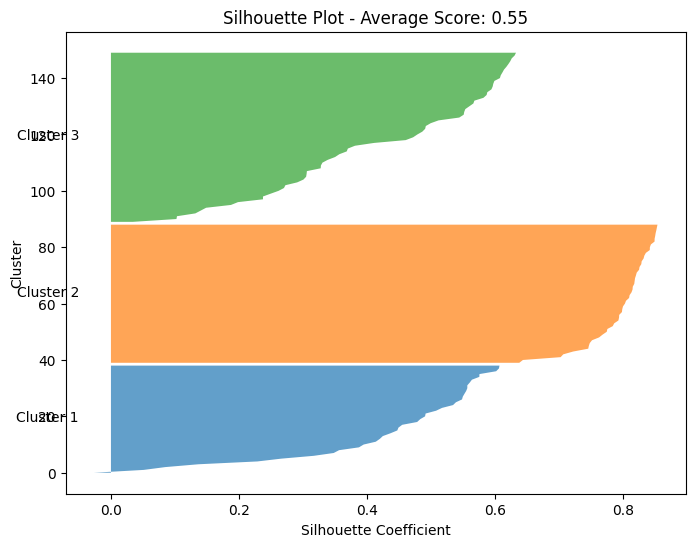

In [20]:
visualize_silhouette(df, labels_random)

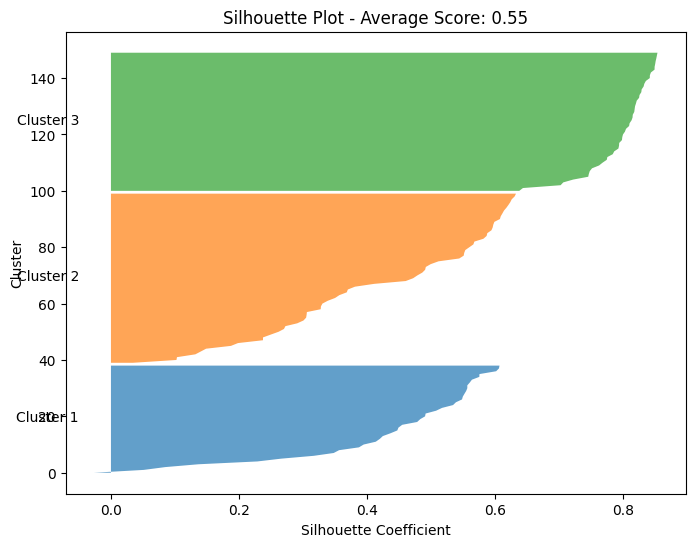

In [21]:
visualize_silhouette(df, labels_picked)

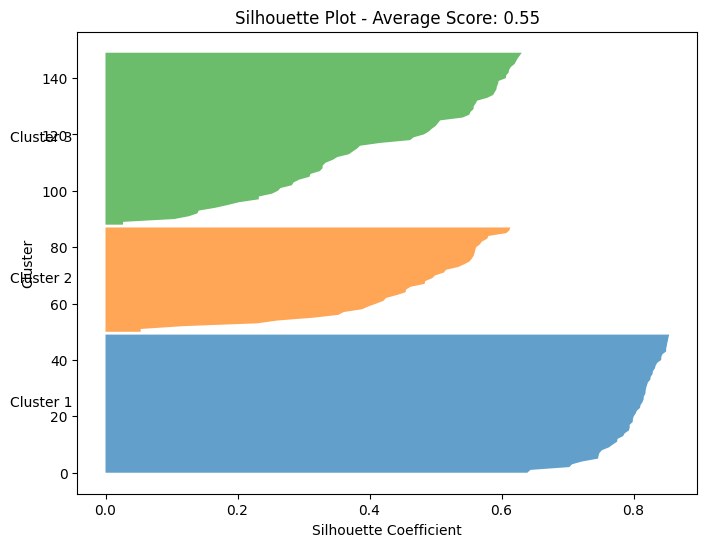

In [22]:
visualize_silhouette(df, labels_kplus)

# **Accuracy Score**

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score
kmeans = KMeans(n_clusters=4, random_state=42)
predicted_labels = kmeans.fit_predict(df)

In [24]:
def accuracy_score(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    label_mapping = np.argmax(cm, axis=1)
    mapped_pred_labels = np.array([label_mapping[label] for label in predicted_labels])
    accuracy = np.mean(mapped_pred_labels == true_labels)
    return accuracy

In [25]:
#Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Cluster Matching Accuracy: {accuracy * 100:.2f}%")

Cluster Matching Accuracy: 15.33%


In [26]:
#silhouette score
silhouette = silhouette_score(df, predicted_labels)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.50
